In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/Jacklin/anaconda3/lib/python3.6/site-packages/')
import gym

# 建立DDPG模型

In [2]:
class DDPG:
    
    def __init__(
        self, 
        n_actions, 
        n_states, 
        gamma = 0.9, #遠見程度
        epsilon = None,  #保守程度，越大就越容易用Q值大小來採取行動；越小則越容易產生隨機行動
        epsilon_increase = None,
        A_learning_rate = 0.001,
        C_learning_rate = 0.001,#神經網路的更新率
        memory_size = 500, #####
        batch_size = 32, #####
        nueron_num = 10
    ):
    
        self.n_actions = n_actions
        self.n_states = n_states
        self.gamma = gamma
        self.epsilon_max = epsilon #####
        self.epsilon_increase = epsilon_increase #####
        self.epsilon = 0 if epsilon_increase is not None else epsilon #####
        self.A_lr = A_learning_rate
        self.C_lr = C_learning_rate
        self.memory_size = memory_size #####
        self.memory_counter = 0 #####
        self.batch_size = batch_size ####
        self.nueron_num = nueron_num
        ##### initialize memory
        self.memory = np.zeros((self.memory_size, n_states * 2 + 2))
        
        
        tf.reset_default_graph() ## 重新 build graph 需要跑這行
        self.sess = tf.Session() #宣告session
        #輸入狀態
        self.state_input = tf.placeholder(shape = [None, self.n_states], 
                                          name = 'state_input',
                                          dtype = tf.float32)
        #輸入行動
        self.action_input = tf.placeholder(shape = [None, self.n_actions], 
                                           name = 'action_input',
                                           dtype = tf.float32)
        
        
        self.q_target = tf.placeholder(shape= [None, 1], 
                                     name="q_target",
                                     dtype = tf.float32)
        #搭建神經網路
        with tf.variable_scope('Actor'):
            self.a_eval = self.build_Anetwork(self.nueron_num, Trainable = True, \
                                              scope = 'net_eval')
            self.a_target = self.build_Anetwork(self.nueron_num, Trainable = False, \
                                                scope = 'net_target')
        
        with tf.variable_scope('Critic'):
            self.q_eval = self.build_Cnetwork(self.nueron_num,
                                              Trainable = True, 
                                              scope = 'net_eval')
            self.q_next = self.build_Cnetwork(self.nueron_num,
                                              Trainable = False, 
                                              scope = 'net_target')    
            
        
        #管理神經網路的parameters
        self.Actor_eval_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                                   scope='Actor/net_eval')
        self.Actor_target_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                                     scope='Actor/net_target')
        self.Critic_eval_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                                    scope='Critic/net_eval')
        self.Critic_target_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                                      scope='Critic/net_target')
        
        #更新舊神經網路的參數
        self.replace_Anet_params = [tf.assign(old, new) for old, 
                                   new in zip(self.Actor_target_params, 
                                   self.Actor_eval_params)]
        
        self.replace_Cnet_params = [tf.assign(old, new) for old, 
                                   new in zip(self.Critic_target_params, 
                                   self.Critic_eval_params)]
        
        #loss
        #q_target = self.reward + self.gamma*self.q_next
        #Critic_eval的BP
        self.C_loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        self.C_train = tf.train.RMSPropOptimizer(self.C_lr).minimize(self.C_loss, var_list=self.Critic_eval_params)
        
        #Actor_eval的BP
        """
        使actor往可以提高q值得方向更新，所以得求 (dq/da)*(da/da_params)。
        """
        self.q_a_grad = tf.gradients(ys = self.q_eval, xs = self.action_input)[0]
        self.policy_grad = tf.gradients(ys = self.a_eval, 
                                        xs = self.Actor_eval_params, 
                                        grad_ys = self.q_a_grad)

        self.A_train = tf.train.RMSPropOptimizer(-self.A_lr).apply_gradients(zip(self.policy_grad, self.Actor_eval_params))
    
        self.sess.run(tf.global_variables_initializer()) #將神經網路初始化
    
    def write_memory(self, current_state, next_state, reward, action): #####
        env_info = np.concatenate([current_state, next_state, [reward], [action]]) 
        save_index = self.memory_counter%self.memory_size
        self.memory[save_index, :] = env_info
        self.memory_counter+=1
        if self.memory_counter%self.memory_size == 0:
            self.memory_counter = self.memory_size
    
    def build_Anetwork(self, neuron_num, Trainable, scope): 
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            
            x1_h1 = tf.layers.dense(inputs = self.state_input, units = neuron_num, \
                   activation = tf.nn.relu, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable) 
            x1_h2 = tf.layers.dense(inputs = x1_h1, units = neuron_num, \
                   activation = tf.nn.relu, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable)
             
             #在continuous的版本output為動作的機率分佈，這邊以機率分布的mean值和std
             #當成神經網路的輸出值。這邊輸出值為mean1, mean2,... std1, std2,...。
             
            output = tf.layers.dense(inputs = x1_h2, units = self.n_actions, \
                   activation = tf.nn.tanh, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable)*2

        return output #輸出‘不同動作’對應值 
    
    def build_Cnetwork(self, neuron_num,  Trainable, scope): 
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            
            state_action_input = tf.concat([self.state_input, self.action_input], axis = 1)
            
            x_h1 = tf.layers.dense(inputs = state_action_input, units = neuron_num, \
                   activation = tf.nn.relu, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable) 
            
            #x_h2 = tf.concat([x1_h1, x2_h1], axis = 1)
            
            #output1 = tf.layers.dense(inputs = x1_h2, units = 1, \
            #                         kernel_initializer=init_w, \
            #                         activation = tf.nn.tanh,\
            #                         bias_initializer=init_b, trainable=Trainable)
            
            x_h2 = tf.layers.dense(inputs = x_h1, units = neuron_num, \
                   activation = tf.nn.relu, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable) 
            
            #x_h2 = tf.concat([x1_h1, x2_h1], axis = 1)
            
            #x1_h2 = tf.layers.dense(inputs = x1_h1, units = neuron_num, \
            #       activation = tf.nn.relu, kernel_initializer=init_w, \
            #       bias_initializer=init_b, trainable=Trainable)
            
            output = tf.layers.dense(inputs = x_h2, units = 1, \
                                     kernel_initializer=init_w, \
                                     bias_initializer=init_b, trainable=Trainable)
            #output = output1 + output2

            
        
        return output #輸出Q(s,a)
    
    def build_dueling_network(self, neuron_num, Trainable, scope):      
        
        state_action_input = tf.concat([self.state_input, self.action_input], axis = 1)
        
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            h1 = tf.layers.dense(inputs = state_action_input, 
                                       units = neuron_num, 
                                       activation = tf.nn.relu, 
                                       kernel_initializer=init_w, 
                                       bias_initializer=init_b, 
                                       trainable=Trainable) 
            #build state value network
            with tf.variable_scope('state_value'):
                

                v_h2 = tf.layers.dense(inputs = h1, 
                                       units = neuron_num, 
                                       activation = tf.nn.relu, 
                                       kernel_initializer=init_w, 
                                       bias_initializer=init_b, 
                                       trainable=Trainable)  

                state_value = tf.layers.dense(inputs = v_h2, 
                                              units = 1, 
                                              kernel_initializer=init_w, 
                                              bias_initializer=init_b, 
                                              trainable=Trainable)
            
            #build advantage network
            with tf.variable_scope('advantage'):
                a_h2 = tf.layers.dense(inputs = h1, 
                                       units = neuron_num, 
                                       activation = tf.nn.relu, 
                                       kernel_initializer=init_w, 
                                       bias_initializer=init_b, 
                                       trainable=Trainable)  

                advantage = tf.layers.dense(inputs = a_h2, 
                                            units = self.n_actions, 
                                            kernel_initializer=init_w, 
                                            bias_initializer=init_b, 
                                            trainable=Trainable)
            #將state value和advantage相加
            output = state_value + (advantage - tf.reduce_mean(advantage, axis=1, keep_dims=True))
            
        return output #輸出‘不同動作’對應的Q值            
 
    def write_memory(self, current_state, next_state, reward, action): #####
        env_info = np.concatenate([current_state, next_state, [reward], action]) 
        save_index = self.memory_counter%self.memory_size
        self.memory[save_index, :] = env_info
        self.memory_counter+=1
        if self.memory_counter%self.memory_size == 0:
            self.memory_counter = self.memory_size        
    
    
    def Actor_learn(self, update_params, current_state, action): #####
        
        if update_params: #####
            self.sess.run(self.replace_Anet_params)
        
        
        #a = self.sess.run(self.q_a_grad, feed_dict={self.state_input: current_state[np.newaxis,:],
        #                                       self.action_input: self.action})
        #print(a)
        self.sess.run(self.A_train, feed_dict={self.state_input: current_state[np.newaxis,:],
                                               self.action_input: action[np.newaxis,:]})
    
    def Critic_learn(self, update_params): #####
        
        if update_params: #####
            self.sess.run(self.replace_Cnet_params)
            #print('update parameters')
        
        #####從記憶中抽取過去的經驗來做更新
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        past_experience = self.memory[sample_index, :]
        
        current_state = past_experience[:, 0:self.n_states]
        next_state = past_experience[:, self.n_states:self.n_states*2]
        reward = past_experience[:, self.n_states*2]
        action = past_experience[:, self.n_states*2+1]

        #利用actor_taget給出下一步的動作
        next_action = self.sess.run(self.a_target, feed_dict={self.state_input: next_state})
        q_next = self.sess.run(self.q_next, feed_dict={self.state_input: next_state,
                                                       self.action_input: next_action})

        q_target = reward[:,np.newaxis] + self.gamma*q_next
       
        _, self.cost = self.sess.run([self.C_train, self.C_loss], 
                                      feed_dict={self.state_input: current_state,
                                                 self.action_input: action[:, np.newaxis],
                                                 self.q_target: q_target})   
        # increasing epsilon
        #self.epsilon = self.epsilon + self.epsilon_increase if self.epsilon < self.epsilon_max else self.epsilon_max  
    
    def choose_action(self, current_state):
        self.action = self.sess.run(self.a_eval, feed_dict={self.state_input: current_state[np.newaxis,:]})
        return self.action[:,0]
    def index_generator(self, size):
        i = 0
        while True:
            if (i+1)*self.batch_size< size:
                index = np.arange(i*self.batch_size,(i+1)*self.batch_size)
                i+=1
                yield index
            else:
                index= np.arange(i*self.batch_size,size)
                yield index
                break  
            
        
    def model_save(self, model_name):
        
        saver = tf.train.Saver()
        saver.save(self.sess, "saved_models/{}.ckpt".format(model_name))
    
    def model_restore(self, model_name):
        
        saver = tf.train.Saver()
        saver.restore(self.sess, "saved_models/{}.ckpt".format(model_name))

In [3]:
def training(save_model, model_name):
    update_count = 0
    learn_count = 0
    step_record = []
    reward_record = []
    var = 3
    for episode in range(500):
        # initial environment並給出起始的state
        current_state = env.reset()
        step = 0
        total_reward = 0
        while True:
            # 產生環境視窗
            if episode >= 70:
                env.render()

            # 根據現在的狀態選擇動作
            action = RL.choose_action(current_state)
            
            action = np.clip(np.random.normal(action, var), -2, 2) 

            # 產生動作和環境互動後產生下一個狀態、獎勵值及遊戲是否結束
            next_state, reward, done, _ = env.step(action)
            
            total_reward+= reward
            
            
            if step == 200:
                done = True
            
            if learn_count > 500 : 
                var *= .9995
                if update_count <300:
                    
                    RL.Actor_learn(False, current_state, action)
                    RL.Critic_learn(update_params = False)
                    update_count+=1
                else: 
                    RL.Actor_learn(True, current_state, action)
                    RL.Critic_learn(update_params = True)
                    update_count = 0
            else:
                learn_count+=1
            
            # 將資訊存至記憶體
            RL.write_memory(current_state, next_state, reward/20, action)
       
            
            current_state = next_state

            # break while loop when end of this episode
            if done:
                mean_reward = total_reward/step
                print('episode:{} steps:{} total_reward:{}'.format(episode, step, total_reward))
                step_record.append(total_reward)
                reward_record.append(mean_reward)
                break
            step += 1

    # end of game
    if save_model:
        RL.model_save(model_name)
    print('game over')
    env.close()
    return step_record, reward_record

In [4]:
step_result = []
reward_result = []
env = gym.make('Pendulum-v0')
env.seed(1)     # reproducible, general Policy gradient has high variance
env = env.unwrapped
RL = DDPG(n_actions = 1, 
          n_states = 3,
          gamma = 0.95,
          memory_size = 10000,
          batch_size = 32,
          nueron_num = 10)
step_record, reward_record = training(save_model = True, model_name='DDPG_Cartpole')

episode:0 steps:200 total_reward:-1107.3947802371297
episode:1 steps:200 total_reward:-1087.3822696713494
episode:2 steps:200 total_reward:-1213.9739801890146
episode:3 steps:200 total_reward:-1620.1186332818572
episode:4 steps:200 total_reward:-1227.5932208378406
episode:5 steps:200 total_reward:-1437.729067397012
episode:6 steps:200 total_reward:-1342.7108087582437
episode:7 steps:200 total_reward:-1217.72434150622
episode:8 steps:200 total_reward:-1483.0471930578492
episode:9 steps:200 total_reward:-1417.2823910399502
episode:10 steps:200 total_reward:-1213.366547548377
episode:11 steps:200 total_reward:-1470.5848734459607
episode:12 steps:200 total_reward:-1345.772814296528
episode:13 steps:200 total_reward:-1467.1432030384883
episode:14 steps:200 total_reward:-1458.88693717992
episode:15 steps:200 total_reward:-1337.788023479924
episode:16 steps:200 total_reward:-1063.16705192476
episode:17 steps:200 total_reward:-1405.6012070762854
episode:18 steps:200 total_reward:-1407.35882491

episode:153 steps:200 total_reward:-0.32196446905369397
episode:154 steps:200 total_reward:-987.1682006033841
episode:155 steps:200 total_reward:-129.60879945020253
episode:156 steps:200 total_reward:-970.1743370722751
episode:157 steps:200 total_reward:-654.789902141506
episode:158 steps:200 total_reward:-270.78664776580325
episode:159 steps:200 total_reward:-750.7325153525244
episode:160 steps:200 total_reward:-273.7736690675931
episode:161 steps:200 total_reward:-422.3095303995601
episode:162 steps:200 total_reward:-266.18684134565865
episode:163 steps:200 total_reward:-1.9593904596603988
episode:164 steps:200 total_reward:-133.9181039702078
episode:165 steps:200 total_reward:-128.781751654639
episode:166 steps:200 total_reward:-810.3083780280856
episode:167 steps:200 total_reward:-273.5348953083545
episode:168 steps:200 total_reward:-274.3869183768352
episode:169 steps:200 total_reward:-1272.9585746279722
episode:170 steps:200 total_reward:-280.15460843290435
episode:171 steps:200 

episode:304 steps:200 total_reward:-1502.911336313096
episode:305 steps:200 total_reward:-133.27297679920667
episode:306 steps:200 total_reward:-3.4270523004896956
episode:307 steps:200 total_reward:-1347.4834248986915
episode:308 steps:200 total_reward:-1156.6452300980152
episode:309 steps:200 total_reward:-1201.9739546477097
episode:310 steps:200 total_reward:-300.770565700266
episode:311 steps:200 total_reward:-1087.3899257722296
episode:312 steps:200 total_reward:-1508.4171192077763
episode:313 steps:200 total_reward:-1140.663305384268
episode:314 steps:200 total_reward:-1056.1469677774664
episode:315 steps:200 total_reward:-1509.32161551157
episode:316 steps:200 total_reward:-657.2395165261529
episode:317 steps:200 total_reward:-1516.8338722802291
episode:318 steps:200 total_reward:-1504.8794080448213
episode:319 steps:200 total_reward:-1648.1139282062077
episode:320 steps:200 total_reward:-1531.2761306008065
episode:321 steps:200 total_reward:-1533.4227190982663
episode:322 steps

episode:455 steps:200 total_reward:-131.8888163368479
episode:456 steps:200 total_reward:-1.846242286327329
episode:457 steps:200 total_reward:-1.2915321536647058
episode:458 steps:200 total_reward:-1470.6146741663972
episode:459 steps:200 total_reward:-1278.412504539712
episode:460 steps:200 total_reward:-1643.0267629234627
episode:461 steps:200 total_reward:-1609.4477981701225
episode:462 steps:200 total_reward:-1552.6281484734338
episode:463 steps:200 total_reward:-1643.1308233234042
episode:464 steps:200 total_reward:-1576.4092951869238
episode:465 steps:200 total_reward:-1578.9011462568114
episode:466 steps:200 total_reward:-1325.2112779115062
episode:467 steps:200 total_reward:-1427.7803525877769
episode:468 steps:200 total_reward:-954.7959518635145
episode:469 steps:200 total_reward:-1277.2059508434525
episode:470 steps:200 total_reward:-809.2826513032632
episode:471 steps:200 total_reward:-138.2369860927046
episode:472 steps:200 total_reward:-943.7397792421099
episode:473 steps

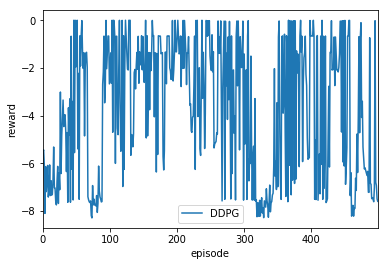

In [5]:
reward_result = pd.DataFrame(reward_record, columns=['DDPG'])
reward_result.plot()
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

In [6]:
reward_result.to_csv('Pendulum_DDPG.csv', index=False)

In [7]:
reward_result = pd.concat([pd.read_csv('Pendulum_DDPG.csv'), pd.read_csv('Pendulum_DDPG_dueling.csv')])

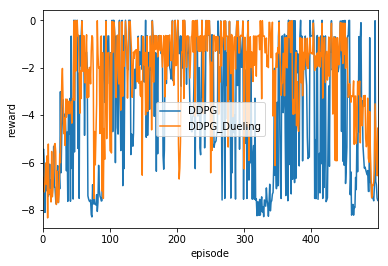

In [8]:
reward_result.plot()
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

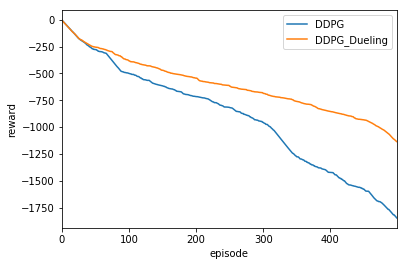

In [9]:
reward_result.cumsum().plot()
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()